In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

In [4]:
def readAbyss(fname, num_particles=2,base_path="../data/output/", time_max=100):
    ## I have to modify the abyss code to incorporate the number of particles within the output data
    with open(base_path+fname) as f:
        time = 0
        lines = f.readlines()
        particles = np.zeros((len(lines)//(num_particles+1),num_particles,20))
        for line in lines[2:]:
            data = np.array(line.split())
            if data[0] == ">>>>":
                continue 
            #data = [float(i) for i in data] 
            #particles.append(Particle(np.array([float(data[i+1]) for i in range(3)]), np.array([float(data[i+4]) for i in range(3)]), np.array([float(data[i+6]) for i in range(12)]).reshape(3,4), float(data[0]), float(data[-1]))) # assuming 3D position, velocity, acceleration, mass, timestep in the input file.
            particles[time//num_particles,int(data[0]),:] = data[1:]
            #print(data[1:])
            time += 1
            if time//num_particles > time_max:
                return particles
    return particles


def compute_energy(positions, velocities, masses, G=1):
    """Computes the total energy (kinetic + potential) of an N-body system."""
    kinetic_energy = 0.5 * np.sum(masses * np.linalg.norm(velocities, axis=1)**2)
    potential_energy = 0.0

    N = len(masses)
    for i in range(N):
        for j in range(i + 1, N):
            r_ij = np.linalg.norm(positions[i,:] - positions[j,:])
            potential_energy -= G * masses[i] * masses[j] / r_ij
    print("kin=",kinetic_energy)
    print("pot=",potential_energy)
    return kinetic_energy + potential_energy

"""
def compute_energy(self): 
    kinetic_energy   = 0.5 * (self.particle1[:,-1] * torch.norm(self.particle1[:,2:4], p=2, dim=1)**2+self.particle2[:,-1] * torch.norm(self.particle2[:,2:4], p=2, dim=1)**2)
    r = torch.norm(self.particle1[:,:2] - self.particle2[:,:2], p=2, dim=1)
    potential_energy = self.particle1[:,-1] * self.particle2[:,-1] / r
    return kinetic_energy + potential_energy
    """

def compute_timestep(acc):
    a1 = np.linalg.norm(acc[:,:3]  ,axis=1)
    a2 = np.linalg.norm(acc[:,3:6] ,axis=1)
    a3 = np.linalg.norm(acc[:,6:9] ,axis=1)
    a4 = np.linalg.norm(acc[:,9:12],axis=1)
    dt = np.sqrt((a1*a3+a2**2)/(a2*a4+a3**2))
    return dt

class Particle:
    def __init__(self, position, velocity, acceleration, mass, timestep):
        self.Position = position
        self.Velocity = velocity
        self.Acceleration = acceleration
        self.Mass = mass
        self.TimeStep = timestep
        #self.Energy = energy


# AbyssData to ML dataset

## Two Body Without Tidal Fields

### Plotting the data

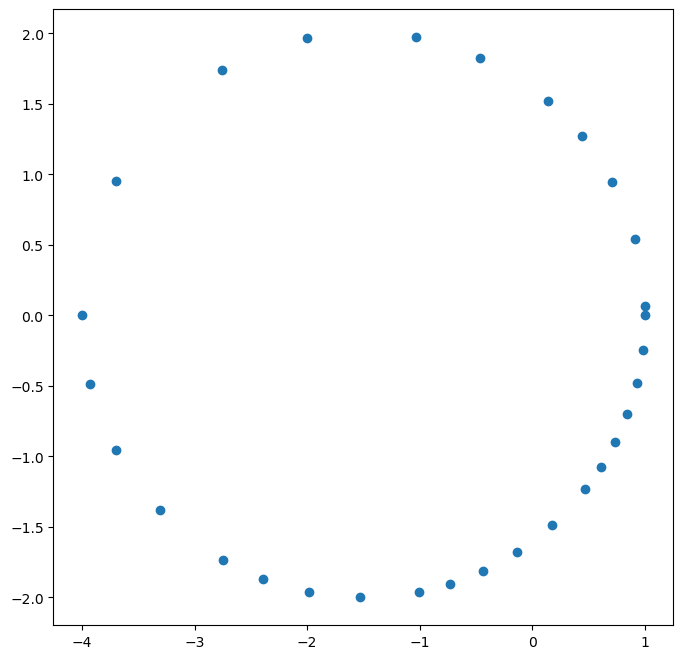

In [34]:
n = 110
m=1
particles = readAbyss(f"two_body_{int(n+1)}_{int(m+1)}.txt")

#particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]

plt.figure(figsize=(8,8))
plt.scatter(particles[:,0,1]-particles[:,1,1], particles[:,0,2]-particles[:,1,2])
#plt.scatter(, )

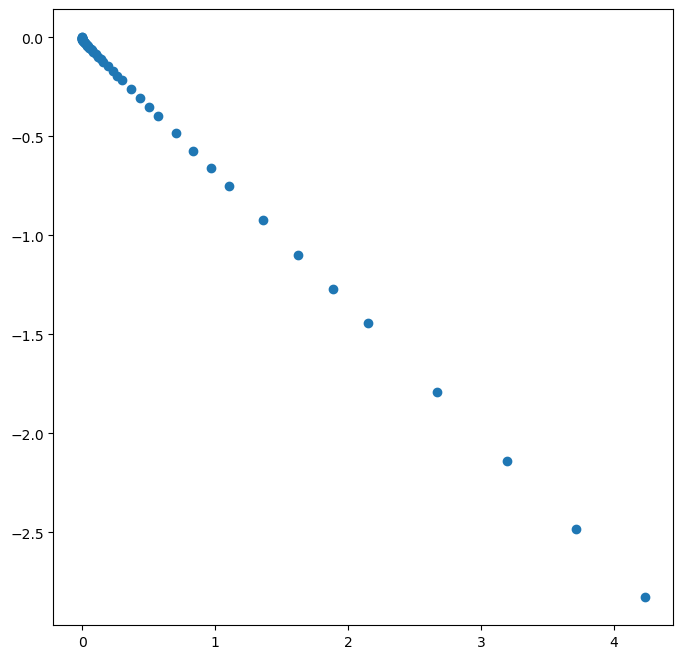

In [67]:
n = 12
m=2
particles = readAbyss(f"two_body_{int(n+1)}_{int(m+1)}_new.txt")

#particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]

plt.figure(figsize=(8,8))
plt.scatter(particles[:,0,1]-particles[:,1,1], particles[:,0,2]-particles[:,1,2])
#plt.scatter(, )

### For Preliminary version which matches up with the first section of Simple_NN.ipynb

#### old

In [4]:
#particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]
data = list()
for n in range(231):
    #for m in range(10):
    m = 5 
#for n in range(1):
#    for m in range(1):
    particles = readAbyss(f"two_body_{int(n+1)}_{int(m+1)}.txt")
    E0 = compute_energy(particles[0,:,1:4], particles[0,:,4:7], particles[0,:,0])
    for t in range(particles.shape[0]-1):
        ptcl = np.zeros(())
        E1 = compute_energy(particles[t+1,:,1:3], particles[t+1,:,4:6], particles[t+1,:,0])
        #data_tmp = np.append(E0,particles[t,0,[0,1,2,4,5,7,8,10,11,13,14,16,17,19]])
        #data_tmp = np.append(data_tmp, particles[t,1,[0,1,2,4,5,7,8,10,11,13,14,16,17,19]])
        data_tmp = np.append(particles[t,0,[1,2,4,5,7,8,10,11,13,14,16,17,0]], particles[t,1,[1,2,4,5,7,8,10,11,13,14,16,17,0]])
        data_tmp = np.append(data_tmp, np.abs((E1-E0)/E0))
        data_tmp = np.append(data_tmp, E0)
        data_tmp = np.append(data_tmp, particles[t,0,-1])
        data.append(data_tmp)
        data_tmp = np.append(particles[t,1,[1,2,4,5,7,8,10,11,13,14,16,17,0]], particles[t,0,[1,2,4,5,7,8,10,11,13,14,16,17,0]])
        data_tmp = np.append(data_tmp, np.abs((E1-E0)/E0))
        data_tmp = np.append(data_tmp, E0)
        data_tmp = np.append(data_tmp, particles[t,1,-1])
        data.append(data_tmp)
        #data.append(np.append(particles[t,[0,1,2,4,5,7,8,10,11,13,14,16,17,19]],np.abs((E1-E0)/E0)))
        E0 = E1


#### new

In [9]:
num_particles = 2
data = list()
#for n in range(67):
for n in range(0,200,10):
    m = 2 
    particles = readAbyss(f"two_body_{int(n+1)}_{int(m+1)}.txt", num_particles=num_particles, time_max=1e8)
    E0 = compute_energy(particles[0,:,1:4], particles[0,:,4:7], particles[0,:,0])
    for t in range(particles.shape[0]-1):
        print(f"total={E0:.4e}")
        E1 = compute_energy(particles[t+1,:,1:4], particles[t+1,:,4:7], particles[t+1,:,0])
        dt = compute_timestep(particles[t,:,7:19])
        print("dt_new=", dt, ", dt_old=", particles[t,:,-1])
        #print(E1)
        for i in range(num_particles):
            data_tmp = particles[t,i,:]
            for j in range(1,num_particles):
                data_tmp = np.append(data_tmp, particles[t,i-j,:])
            data_tmp = np.append(data_tmp, np.abs((E1-E0)/E0))
            data_tmp = np.append(data_tmp, E0)
            data.append(data_tmp)
        E0 = E1
data = np.array(data)
data.shape

kin= 24649902755.1
pot= -49308484000.0
total=-2.4659e+10
kin= 24651886273.484005
pot= -49307817362.81569
dt_new= [5.11744851e-06 5.11744851e-06] , dt_old= [1.465e-06 1.465e-06]
total=-2.4656e+10
kin= 24649144027.999996
pot= -49307486657.6925
dt_new= [1.49528362e-05 1.49528362e-05] , dt_old= [1.465e-06 1.465e-06]
total=-2.4658e+10
kin= 24647752618.700005
pot= -49303815899.04101
dt_new= [1.46460344e-05 1.46460344e-05] , dt_old= [2.929e-06 2.929e-06]
total=-2.4656e+10
kin= 24651170577.199997
pot= -49304773107.43056
dt_new= [1.49641523e-05 1.49641523e-05] , dt_old= [5.858e-06 5.858e-06]
total=-2.4654e+10
kin= 24661445167.600006
pot= -49303815899.04101
dt_new= [1.51770563e-05 1.51770563e-05] , dt_old= [5.858e-06 5.858e-06]
total=-2.4642e+10
kin= 24685313268.647118
pot= -49347960429.034164
dt_new= [1.25349501e-05 1.25349501e-05] , dt_old= [5.858e-06 5.858e-06]
total=-2.4663e+10
kin= 24723314956.299995
pot= -49367694232.47014
dt_new= [1.21848484e-05 1.21848484e-05] , dt_old= [5.858e-06 5.858e

(590, 42)

In [10]:
np.save("../data/two_body_train_data_new", data)
data.shape

(590, 42)

## Three Body

### Plotting the data for a test

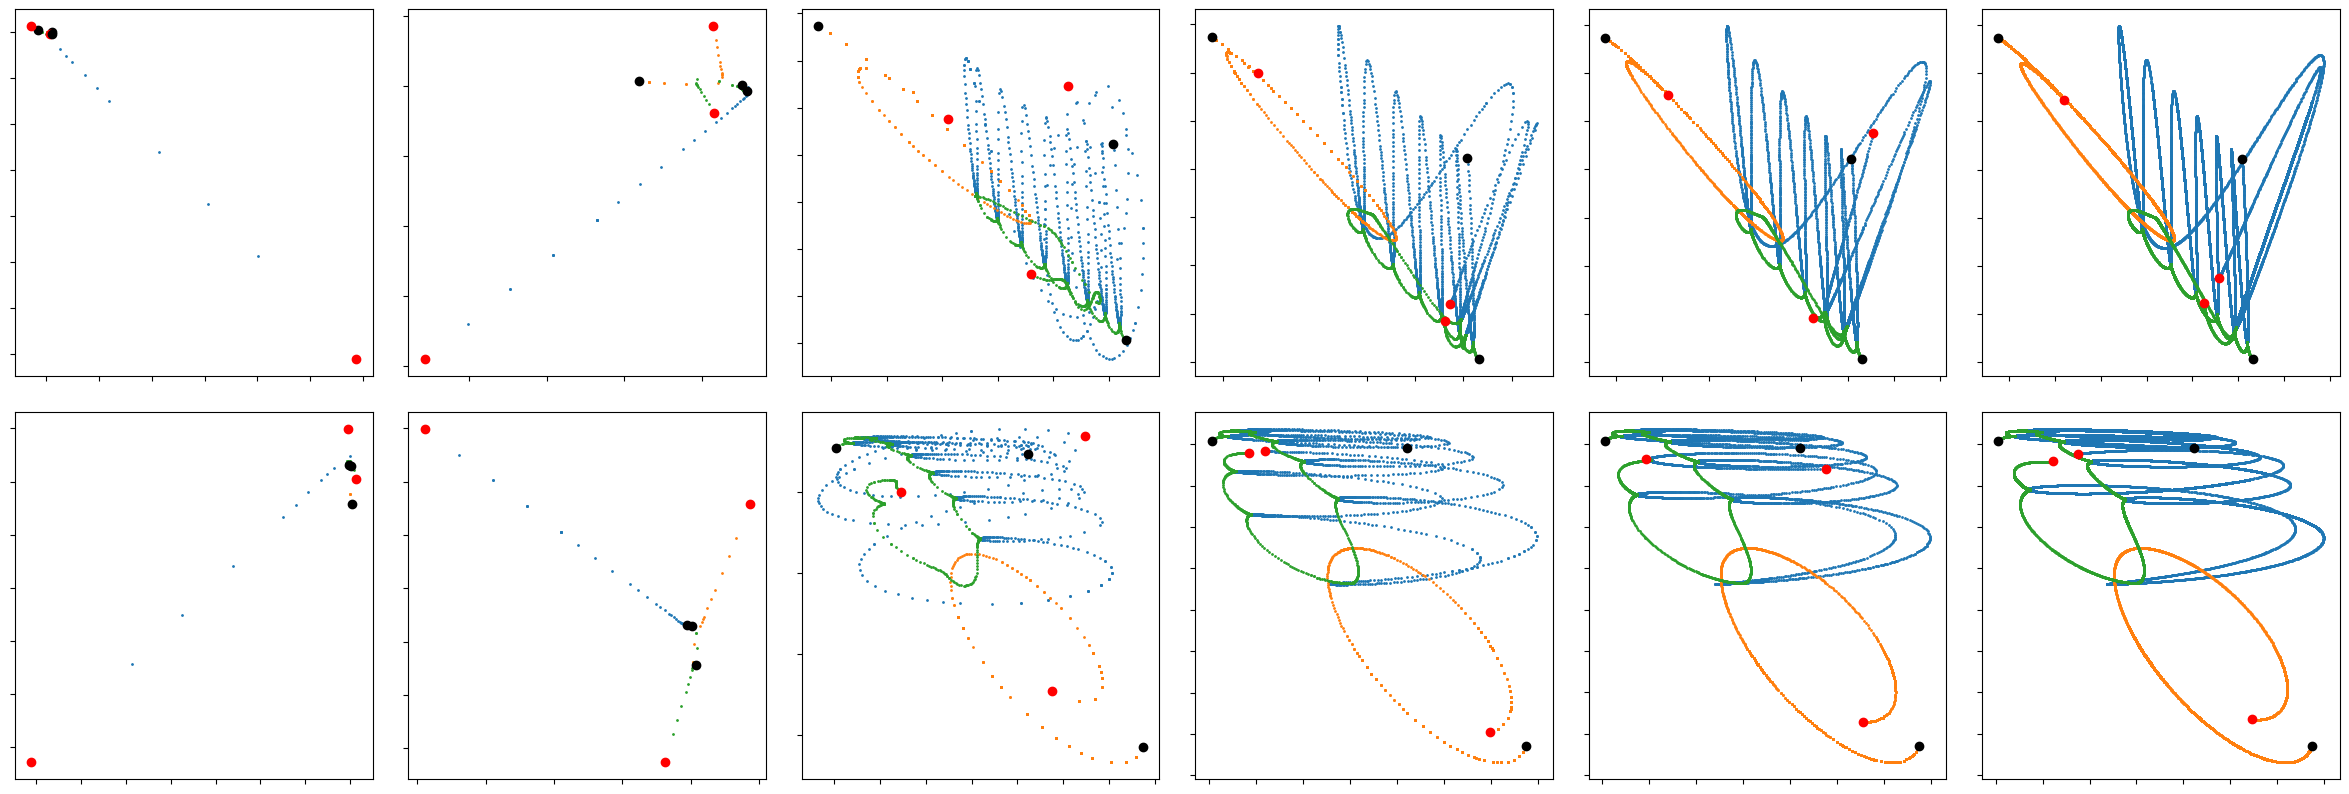

In [66]:
num_particles = 3

fig, axes = pu.generateAxesForMultiplePlots(shape=(6,2),figsize=(30,10),hspace=0.1,wspace=0.1,
                                gridspec=None)

n=62
for m in range(6):
    particles = readAbyss(f"three_body_{int(n+1)}_{int(m+1)}.txt", num_particles=num_particles, time_max=1e8)
    x=m; y=0
    #particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]
    for i in range(3):
        axes[x,y].scatter(particles[0,i,1], particles[0,i,2], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,1], particles[1:-1,i,2], s=1)
        axes[x,y].scatter(particles[-1,i,1], particles[-1,i,2], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])

    y=1
    for i in range(3):
        axes[x,y].scatter(particles[0,i,2], particles[0,i,3], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,2], particles[1:-1,i,3], s=1)
        axes[x,y].scatter(particles[-1,i,2], particles[-1,i,3], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])
    #axes[x,y].axis("off")

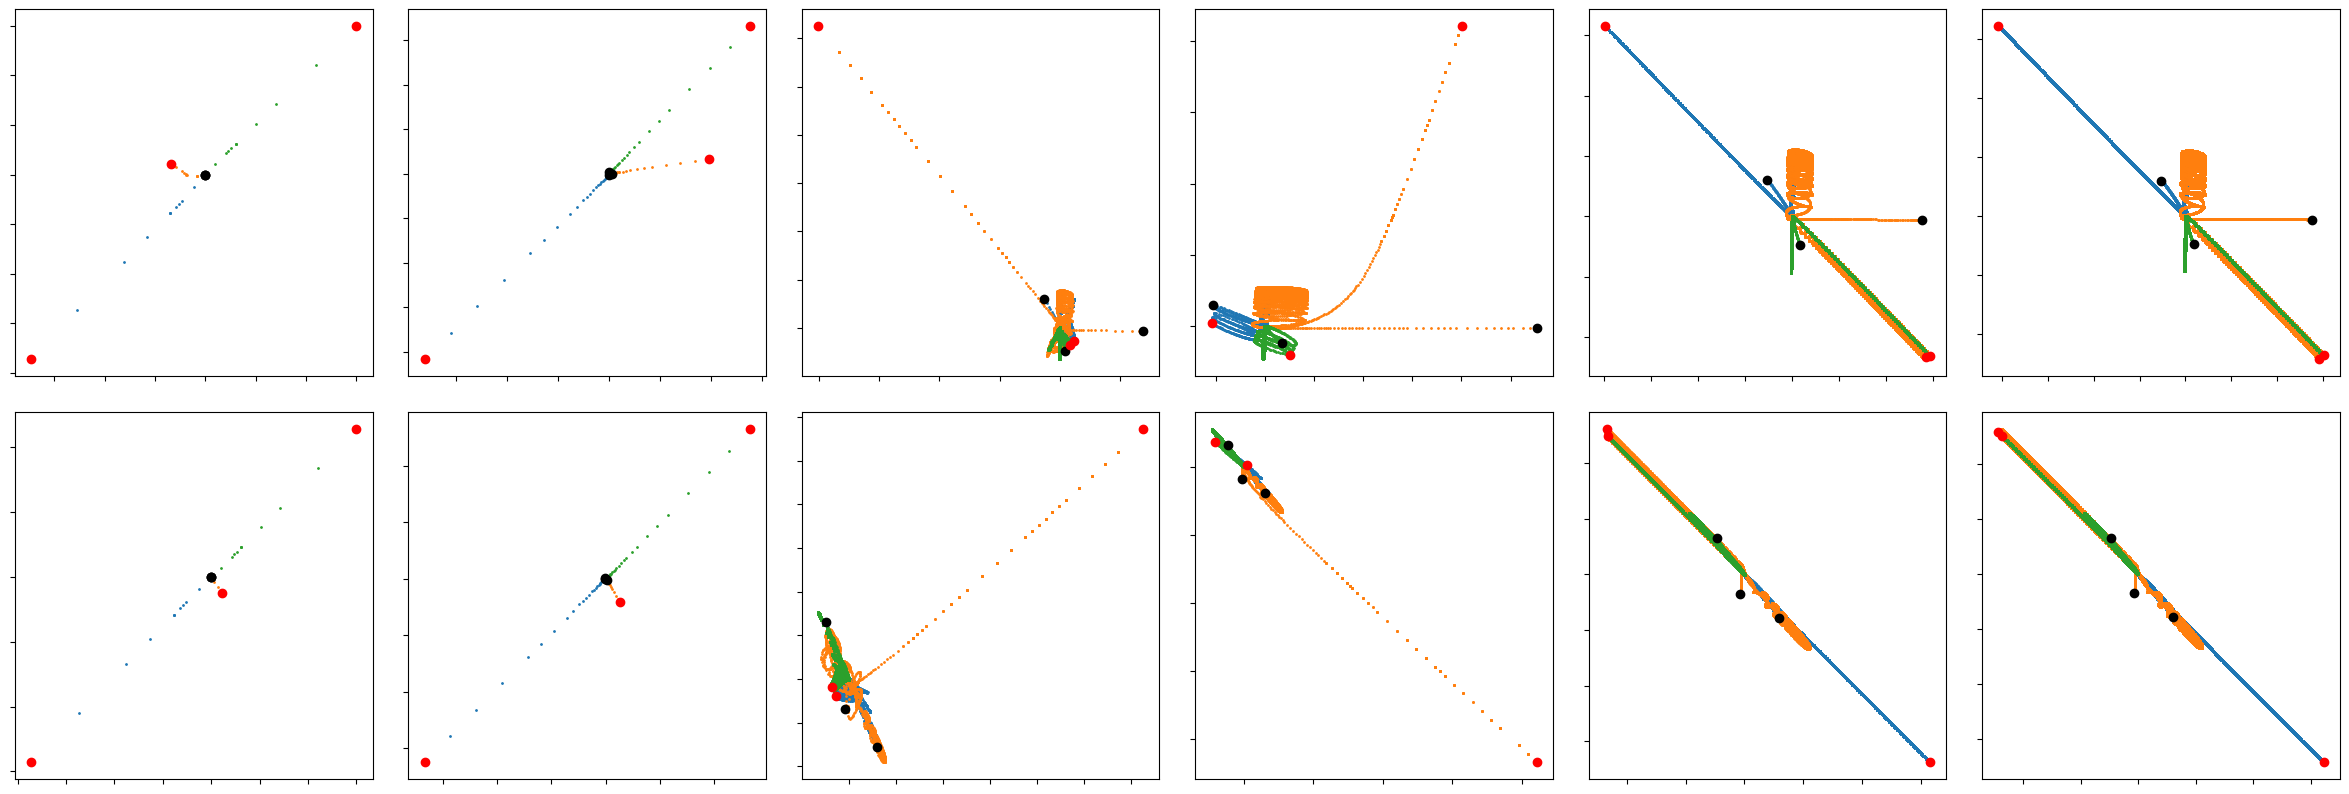

In [69]:
num_particles = 3

fig, axes = pu.generateAxesForMultiplePlots(shape=(6,2),figsize=(30,10),hspace=0.1,wspace=0.1,
                                gridspec=None)

n=54
for m in range(6):
    particles = readAbyss(f"three_body_{int(n+1)}_{int(m+1)}.txt", num_particles=num_particles, time_max=1e8)
    x=m; y=0
    #particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]
    for i in range(3):
        axes[x,y].scatter(particles[0,i,1], particles[0,i,2], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,1], particles[1:-1,i,2], s=1)
        axes[x,y].scatter(particles[-1,i,1], particles[-1,i,2], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])

    y=1
    for i in range(3):
        axes[x,y].scatter(particles[0,i,2], particles[0,i,3], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,2], particles[1:-1,i,3], s=1)
        axes[x,y].scatter(particles[-1,i,2], particles[-1,i,3], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])
    #axes[x,y].axis("off")

/mnt/home/yjo10/pyenv/newvenv/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/yjo10/pyenv/newvenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


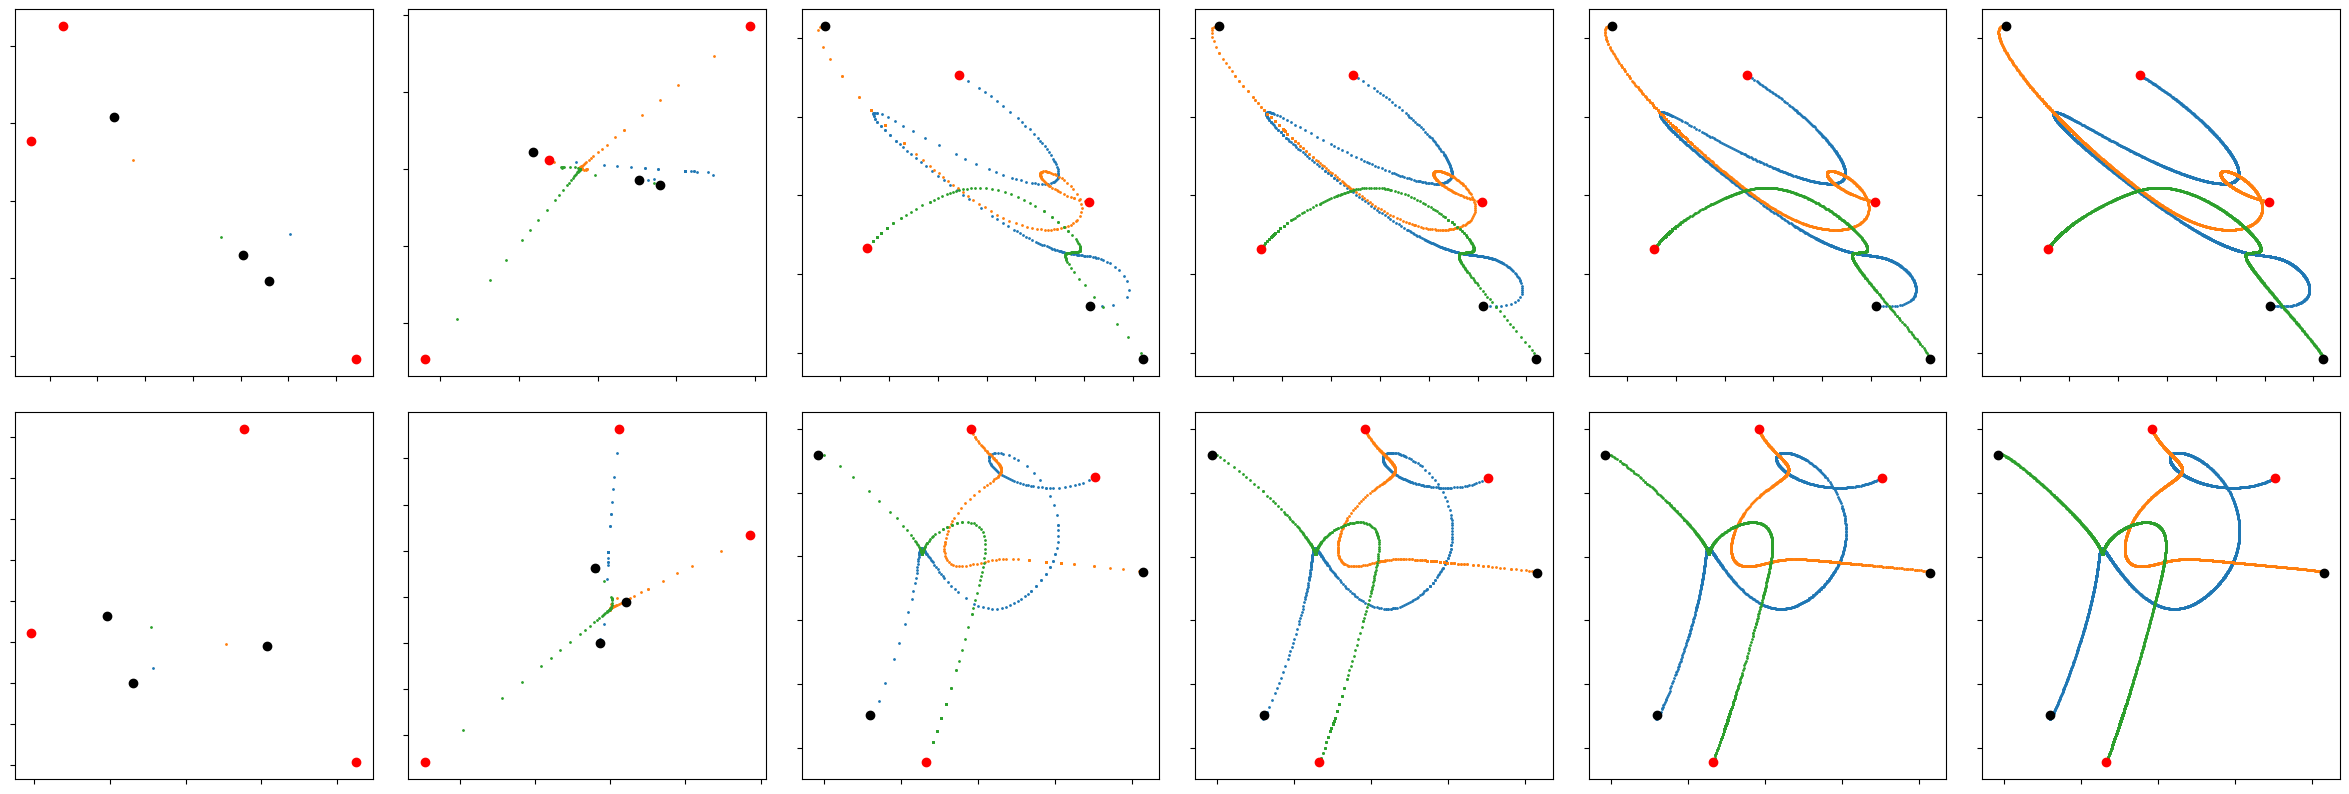

In [15]:
num_particles = 3

fig, axes = pu.generateAxesForMultiplePlots(shape=(6,2),figsize=(30,10),hspace=0.1,wspace=0.1,
                                gridspec=None)

n=0
for m in range(6):
    particles = readAbyss(f"three_body_{int(n+1)}_{int(m+1)}.txt", num_particles=num_particles, time_max=1e8)
    x=m; y=0
    #particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]
    for i in range(3):
        axes[x,y].scatter(particles[0,i,1], particles[0,i,2], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,1], particles[1:-1,i,2], s=1)
        axes[x,y].scatter(particles[-1,i,1], particles[-1,i,2], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])

    y=1
    for i in range(3):
        axes[x,y].scatter(particles[0,i,2], particles[0,i,3], color="k",zorder=10)
        axes[x,y].scatter(particles[1:-1,i,2], particles[1:-1,i,3], s=1)
        axes[x,y].scatter(particles[-1,i,2], particles[-1,i,3], color="r",zorder=10)

    #axes[x,y].set_xlim(-1,1)
    #axes[x,y].set_ylim(-1,1)
    axes[x,y].set_xticklabels([])
    axes[x,y].set_yticklabels([])
    #axes[x,y].axis("off")

### extraction

In [30]:
#particles -> [time, PID, [mass(1), pos(3), vel(3), acc(12->3,4), dt(1)]]
num_particles = 3
data = list()
#for n in range(100):
#    for m in range(1):
#for n in range(31):
#for n in range(100):
#for n in range(2):
#for n in range(0,5):
    #for m in range(3):
for n in range(3):
    m=4
    particles = readAbyss(f"three_body_{int(n+1)}_{int(m+1)}.txt", num_particles=3, time_max=1e8)
    E0 = compute_energy(particles[0,:,1:4], particles[0,:,4:7], particles[0,:,0])
    for t in range(particles.shape[0]-1):
        print(f"total={E0:.4e}")
        E1 = compute_energy(particles[t+1,:,1:4], particles[t+1,:,4:7], particles[t+1,:,0])
        dt = compute_timestep(particles[t,:,7:19])
        print("dt_new=", dt, ", dt_old=", particles[t,:,-1])
        #print(E1)
        for i in range(num_particles):
            data_tmp = particles[t,i,:]
            for j in range(1,num_particles):
                data_tmp = np.append(data_tmp, particles[t,i-j,:])
            data_tmp = np.append(data_tmp, np.abs((E1-E0)/E0))
            data_tmp = np.append(data_tmp, E0)
            data.append(data_tmp)
        E0 = E1

kin= 73576249908194.0
pot= -3035427534517380.0
total=-2.9619e+15
kin= 69172044648194.0
pot= -3031169792037421.5
dt_new= [1.81031208e-05 2.18510471e-05 2.02596893e-05] , dt_old= [7.813e-07 1.563e-06 1.563e-06]
total=-2.9620e+15
kin= 59096719349972.5
pot= -3021146562974716.0
dt_new= [2.59828596e-05 2.18510471e-05 2.02596893e-05] , dt_old= [7.813e-07 1.563e-06 1.563e-06]
total=-2.9620e+15
kin= 48664578805466.414
pot= -3010008379117425.0
dt_new= [2.65048584e-05 2.81388484e-05 2.74066025e-05] , dt_old= [1.563e-06 1.563e-06 1.563e-06]
total=-2.9613e+15
kin= 42128238379026.0
pot= -3003804641753521.0
dt_new= [2.73998466e-05 2.92862397e-05 2.86962647e-05] , dt_old= [1.563e-06 1.563e-06 1.563e-06]
total=-2.9617e+15
kin= 39447512318426.0
pot= -3001484094965379.0
dt_new= [2.82565637e-05 3.03555664e-05 2.97487641e-05] , dt_old= [1.563e-06 1.563e-06 1.563e-06]
total=-2.9620e+15
kin= 40555270550176.0
pot= -3002010351443985.0
dt_new= [2.89413014e-05 3.11633735e-05 3.03956212e-05] , dt_old= [1.563e-06 

In [31]:
data = np.array(data)
np.save("../data/three_body_train_data", data)
data.shape

(18708, 62)

In [29]:
epsilons = np.linspace(1,-3,6)
10**epsilons

array([1.00000000e+01, 1.58489319e+00, 2.51188643e-01, 3.98107171e-02,
       6.30957344e-03, 1.00000000e-03])

In [12]:
data.shape, data[:,-1]

((77928, 62),
 array([-2.96185128e+15, -2.96185128e+15, -2.96185128e+15, ...,
        -3.84427806e+16, -3.84427806e+16, -3.84427806e+16]))

## Two Body With Tidal Fields